In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
class SentenceEmbedder(TransformerMixin):
    """
    Transformer that encodes text into embeddings using SentenceTransformer.
    """
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.embedder = SentenceTransformer(model_name)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Expect list or array of texts
        texts = X if isinstance(X, (list, np.ndarray)) else X.tolist()
        return self.embedder.encode(texts, show_progress_bar=False)

class StackedHateSpeechClassifier(BaseEstimator, ClassifierMixin):
    """
    Pipeline: embed -> scale -> optional PCA -> stack of base learners -> meta model
    Supports custom threshold for binary predict.
    """
    def __init__(self,
                 threshold=0.25,
                 embed_model='all-MiniLM-L6-v2',
                 use_pca=False,
                 pca_components=50,
                 cv=3,
                 n_jobs=-1):
        self.threshold = threshold
        self.embed_model = embed_model
        self.use_pca = use_pca
        self.pca_components = pca_components
        self.cv = cv
        self.n_jobs = n_jobs

        # Base learners
        learners = [
            ('lr', LogisticRegression(max_iter=1000, n_jobs=self.n_jobs)),
            ('rf', RandomForestClassifier(n_jobs=self.n_jobs, random_state=42)),
            ('knn', KNeighborsClassifier()),
            ('nb', GaussianNB()),
            ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=self.n_jobs, random_state=42))
        ]
        
        self.stacker = StackingClassifier(
            estimators=learners,
            final_estimator=LogisticRegression(random_state=42),
            cv=self.cv,
            n_jobs=self.n_jobs
        )

        steps = [
            ('embed', SentenceEmbedder(self.embed_model)),
            ('scale', StandardScaler()),
        ]
        if self.use_pca:
            steps.append(('pca', PCA(n_components=self.pca_components, random_state=42)))
        steps.append(('stack', self.stacker))

        self.pipeline = Pipeline(steps)
        
    def get_params(self, deep=True):
        return {
            "threshold": self.threshold,
            "embed_model": self.embed_model,
            "use_pca": self.use_pca,
            "pca_components": self.pca_components,
            "cv": self.cv,
            "n_jobs": self.n_jobs
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        # Rebuild pipeline if relevant params changed
        self.__init__(
            threshold=self.threshold,
            embed_model=self.embed_model,
            use_pca=self.use_pca,
            pca_components=self.pca_components,
            cv=self.cv,
            n_jobs=self.n_jobs
        )
        return self

    def fit(self, X, y):
        """Train the stacking pipeline."""
        self.pipeline.fit(X, y)
        return self

    def predict_proba(self, X):
        """Return probability estimates for the positive class."""
        probs = self.pipeline.predict_proba(X)
        return probs

    def predict(self, X):
        """Return binary predictions using threshold."""
        probs = self.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)

    def score(self, X, y):
        """F1 score with custom threshold."""
        preds = self.predict(X)
        return f1_score(y, preds)

    def evaluate(self, X, y_true):
        """Generate and print classification report, confusion matrix, and ROC AUC."""
        preds = self.predict(X)
        probs = self.predict_proba(X)[:, 1]
        print("Classification Report:\n", classification_report(y_true, preds))

        cm = confusion_matrix(y_true, preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Hate', 'Hate'],
                    yticklabels=['Not Hate', 'Hate'])
        plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

        fpr, tpr, _ = roc_curve(y_true, probs)
        auc = roc_auc_score(y_true, probs)
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()

/home/juan1guerra/.local/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:59:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[01:59:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[01:59:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[01:59:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.33      0.50       835
           1       0.22      0.94      0.35       163

    accuracy                           0.43       998
   macro avg       0.59      0.64      0.42       998
weighted avg       0.85      0.43      0.47       998



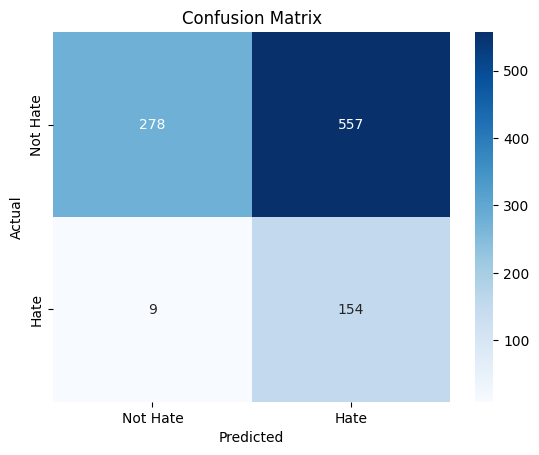

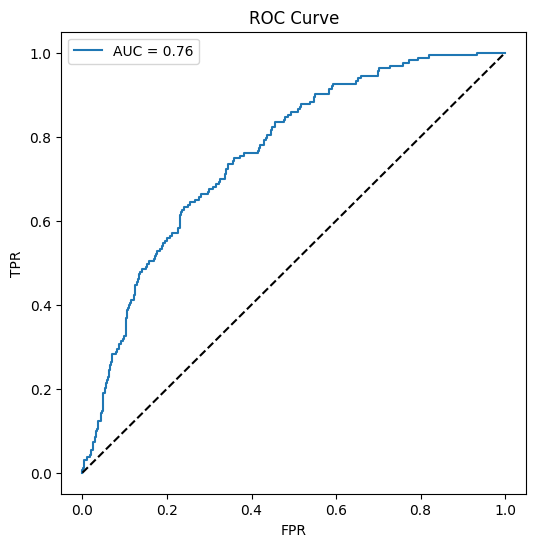

: 

In [4]:
if __name__ == '__main__':
    # Paths
    base_dir = os.getcwd()
    train_df = pd.read_csv(os.path.join(base_dir, '../data/train_data.csv'))
    test_df = pd.read_csv(os.path.join(base_dir, '../data/test_data_clean.csv'))

    X_train, y_train = train_df['text'], train_df['label'].astype(int)
    X_test, y_test = test_df['comment'], test_df['isHate'].astype(int)

    # Initialize with PCA
    model = StackedHateSpeechClassifier(threshold=0.3, use_pca=True, pca_components=50)
    model.fit(X_train, y_train)
    model.evaluate(X_test, y_test)

    # Grid-search for threshold
    from sklearn.model_selection import GridSearchCV
    custom_scorer = make_scorer(f1_score)
    grid = GridSearchCV(
        estimator=model,
        param_grid={'threshold': [0.2, 0.25, 0.3, 0.35, 0.4]},
        scoring=custom_scorer,
        cv=3,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print("Best threshold:", grid.best_params_['threshold'])
    best_model = grid.best_estimator_
    best_model.evaluate(X_test, y_test)